In [1]:
from keras.applications import Xception
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from sklearn.decomposition import PCA

In [2]:
data128 = np.load('../data_preprocessing/img_features128.npy')

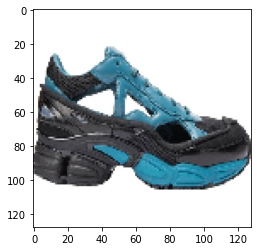

In [3]:
plt.imshow(data128[0])

In [4]:
# imagenetで学習済み。include_topは全結合層を含めるかどうか。imagenetの1000クラス分類に対応。
train_model = Xception(weights = "imagenet",
                 include_top=False,
                 input_shape=(128,128,3))
train_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

block14_sepconv2_bn (BatchNorma (None, 4, 4, 2048)   8192        block14_sepconv2[0][0]           
__________________________________________________________________________________________________
block14_sepconv2_act (Activatio (None, 4, 4, 2048)   0           block14_sepconv2_bn[0][0]        
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
__________________________________________________________________________________________________


In [5]:
feature = train_model.get_layer('block14_sepconv2_act')
print(type(feature))  
print(feature.name, feature.output_shape) 

<class 'tensorflow.python.keras.layers.core.Activation'>
block14_sepconv2_act (None, 4, 4, 2048)


In [6]:
# Globalpooling層の追加
output = layers.GlobalMaxPooling2D()(feature.output)

In [7]:
# 新しいモデル作成
model = models.Model(inputs=train_model.input, outputs=output)

print(model.output_shape)
model.summary()

(None, 2048)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
_________________________________________________________________________________

block7_sepconv2 (SeparableConv2 (None, 8, 8, 728)    536536      block7_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block7_sepconv2_bn (BatchNormal (None, 8, 8, 728)    2912        block7_sepconv2[0][0]            
__________________________________________________________________________________________________
block7_sepconv3_act (Activation (None, 8, 8, 728)    0           block7_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
block7_sepconv3 (SeparableConv2 (None, 8, 8, 728)    536536      block7_sepconv3_act[0][0]        
__________________________________________________________________________________________________
block7_sepconv3_bn (BatchNormal (None, 8, 8, 728)    2912        block7_sepconv3[0][0]            
__________________________________________________________________________________________________
add_5 (Add

In [8]:
model.save(os.path.join('../objects', 'img_cnn.h5'))

In [9]:
# predict()でデータセット画像の特徴抽出
features = model.predict(data128)
print(features.shape) 

(3852, 2048)


### PCAで次元削減

In [10]:
# pca = PCA(n_components=256)

pca = PCA()
pca.fit(features)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

568

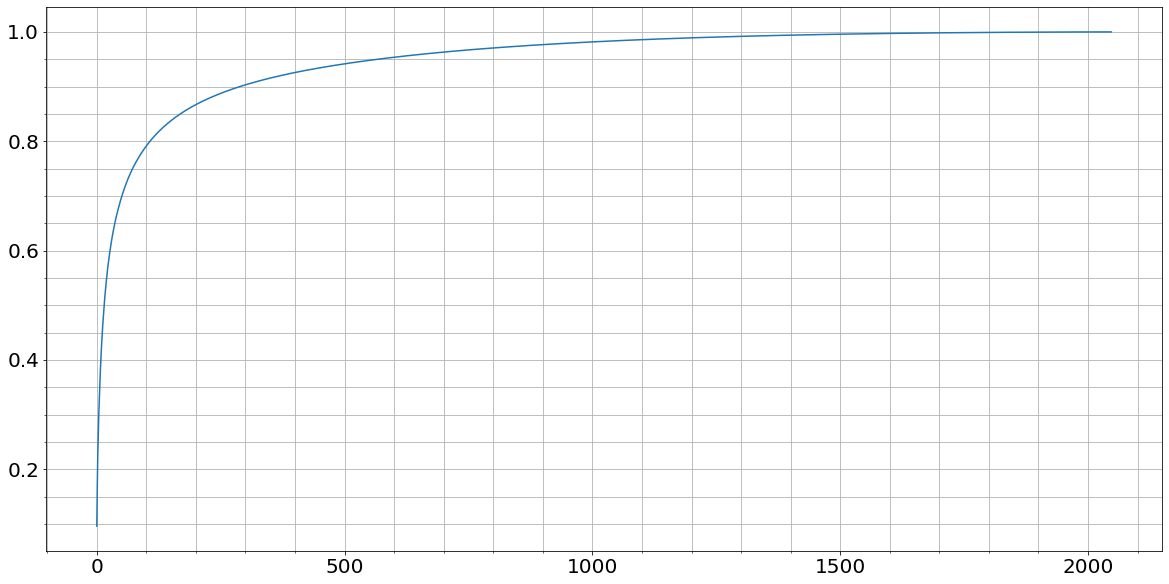

In [11]:
plt.figure(figsize=(20, 10))
plt.rcParams['font.size'] = 20
plt.grid(which='major')
plt.minorticks_on()
plt.grid(which='minor')
plt.plot(cumsum)

In [12]:
pca = PCA(n_components=256)
features_reduced = pca.fit_transform(features)
features_reduced.shape

(3852, 256)

In [13]:
pickle.dump(pca, open(os.path.join('../objects', 'pca.pkl'), 'wb'), protocol=4)

In [14]:
img_xception_256_df = pd.DataFrame(features_reduced)
img_xception_256_df.to_csv('../data/img_features/img_xception_256_df.csv', index=False)